In [12]:
%pylab inline

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
import sys
# from rim_utils import build_rim_parallel, myAdam, build_rim_parallel_single


In [15]:

import tensorflow as tf
import tensorflow_probability as tfp
# import mesh_tensorflow as mtf

sys.path.append('../utils/')
sys.path.append('/mnt/home/cmodi/Research/Projects/flowpm')

import flowpm
# import flowpm.mesh_ops as mpm
# import flowpm.mtfpm as mtfpm
# import flowpm.mesh_utils as mesh_utils
from astropy.cosmology import Planck15
from flowpm.tfpm import PerturbationGrowth
from flowpm import linear_field, lpt_init, nbody, cic_paint
from flowpm.utils import r2c3d, c2r3d
from flowpm.tfpm import lpt1


import tools
import diagnostics as dg

import contextlib
import functools
import math, time
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
import scipy.optimize as sopt


sys.path.append('../code/clean_rim/')
from rim_utils import  build_rim_parallel, myAdam
from modelhalo import HaloData, check_2pt, check_im, get_data, get_diff_spectra
from recon_models import Recon_Bias
# from test_rim import standardrecon

In [16]:
from scipy.optimize import minimize

from pmesh.pm import ParticleMesh
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from nbodykit.lab import BigFileMesh, BigFileCatalog, FFTPower
from nbodykit.cosmology import Planck15, Cosmology



In [17]:

parser = {}
parser['nc'] = 32
parser['ncf'] = 256
parser['bs'] = 400
parser['nsteps'] = 3
parser['numd'] = 1e-3
parser['niter'] = 100
parser['nbody'] = False
parser['lpt_order'] = 2
parser['input_size'] = 8
parser['cell_size'] = 8 
parser['adam_iter'] = 10
parser['rim_iter'] = 10
parser['suffix'] = ' '
parser['posdata'] = True
parser['parallel'] = True
parser['nsims'] = 100
parser['anneal'] = True
parser['stdinit'] = False
parser['prior'] = False


class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
args = Struct(**parser)


In [18]:

nc, bs = args.nc, args.bs
numd = args.numd
num = int(numd*bs**3)
ncf = args.ncf
niter = args.niter
lr = 1e-3
a0, af, nsteps = 0.1, 1.0,  args.nsteps
stages = np.linspace(a0, af, nsteps, endpoint=True)
args.stages = stages
args.a0, args.af = a0, af
args.world_size = 1
if args.posdata : datatype = 'pos'
else : datatype = 'mass'
seed = 599

#
klin = np.loadtxt('../data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../data//Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)
# Compute necessary Fourier kernels                                                                                          
kvec = tools.fftk((nc, nc, nc), boxsize=bs, symmetric=False)
kmesh = (sum(k**2 for k in kvec)**0.5).astype(np.float32)
priorwt = ipklin(kmesh)

args.kmesh = kmesh
args.ipklin = ipklin
args.priorwt = priorwt

datamodel = HaloData(args)


In [19]:
traindata, testdata = get_data(args)


In [20]:

@tf.function
def standardrecon(base, pos, bias, R):

    smwts = tf.exp(tf.multiply(-kmesh**2, R**2))
    basek = r2c3d(base, norm=nc**3)
    basek = tf.multiply(basek, tf.cast(smwts, tf.complex64))
    basesm = c2r3d(basek, norm=nc**3)

    grid = bs/nc*np.indices((nc, nc, nc)).reshape(3, -1).T.astype(np.float32)
    grid = tf.constant(np.expand_dims(grid, 0))
    grid = grid *nc/bs
    pos = pos *nc/bs
        
    mesh = basesm 
    meshk = r2c3d(mesh, norm=nc**3)
    
    DX = lpt1(meshk, pos, kvec=kvec)
    DX = tf.multiply(DX, -1/bias)
    pos = tf.add(pos, DX)
    displaced = tf.zeros_like(mesh)
    displaced = cic_paint(displaced, pos, name='displaced')
    
    DXrandom = lpt1(meshk, grid, kvec)
    DXrandom = tf.multiply(DXrandom, -1/bias)
    posrandom = tf.add(grid, DXrandom)
    random = tf.zeros_like(mesh)
    random = cic_paint(random, posrandom, name='random')
    displaced = displaced / tf.reduce_mean(displaced, axis=(1, 2, 3)) - 1.
    random = random / tf.reduce_mean(random, axis=(1, 2, 3)) - 1.
    recon = displaced - random 
    return recon, displaced, random


In [21]:

def get_sim(seed=seed):
    path = '//mnt/ceph/users/cmodi/cosmo4d/z00/'
    dyn = "%02dstep"%3
    hpath = path + '/L%04d_N%04d_%s//'%(bs, ncf, '20step')
    path = path + '/L%04d_N%04d_%s//'%(bs, nc, dyn)

    ic = tools.readbigfile(path + '/L%04d_N%04d_S%04d_%s/mesh/s/'%(bs, nc, seed, dyn))
    final = tools.readbigfile(path + '/L%04d_N%04d_S%04d_%s/mesh/d/'%(bs, nc, seed, dyn))
    
    hpos = tools.readbigfile(hpath + '/L%04d_N%04d_S%04d_20step/FOF/PeakPosition/'%(bs, ncf, seed))[:num]
    hmassall = tools.readbigfile(hpath + '/L%04d_N%04d_S%04d_20step/FOF/Mass/'%(bs, ncf, seed)).flatten()
    print(hmassall.shape, hmassall.shape[0]/bs**3, hmassall.shape[0]/bs**3 /numd)
    hmass = hmassall[:num]
    print(hmass.shape, hmass.shape[0]/bs**3, hmass.shape[0]/bs**3 /numd)
    hmeshpos = tools.paintcic(hpos, bs, nc)
    hmeshmass = tools.paintcic(hpos, bs, nc, hmass.flatten()*1e10)
    hmeshmass /= hmeshmass.mean()
    hmeshmass -= 1
    hmeshpos /= hmeshpos.mean()
    hmeshpos -= 1
    return ic, final, hmeshpos, hmeshmass, hpos

In [22]:
ic, final, hmeshpos, hmeshmass, hpos = get_sim()
xx = ic.reshape(1, nc, nc, nc).astype(np.float32)
if args.posdata: yy = hmeshpos.reshape(1, nc, nc, nc).astype(np.float32)
else: yy = hmeshmass.reshape(1, nc, nc, nc).astype(np.float32)



###Standard recon
pfin = tools.power(final, boxsize=bs)[1]
ph = tools.power(1+hmeshpos, boxsize=bs)[1]
bias1 = ((ph[1:5]/pfin[1:5])**0.5).mean()
print("Bias : ", bias1)

    

(62455,) 0.000975859375 0.975859375
(62455,) 0.000975859375 0.975859375
Bias :  1.2375483508203386


In [23]:
###RIM Recon
bias, errormesh = datamodel.setupbias(traindata, nsims=10);
print(bias)
grad_params = [bias, errormesh]
b1, b2 = bias.numpy()[0], bias.numpy()[1]


ZA/2LPT sim

Bias fit params are :  1.1058012887249968 -0.31252349521411216 0.0
ZA/2LPT sim

Bias fit params are :  1.0873334807819628 -0.3130114697903309 0.0

Bias fit params are :  1.1012641618589512 -0.34015062010193886 0.0

Bias fit params are :  1.0988018267621975 -0.3392426732342041 0.0

Bias fit params are :  1.1209142432949353 -0.30539933846299333 0.0

Bias fit params are :  1.122635933119219 -0.3602636867431659 0.0

Bias fit params are :  1.1202327352504535 -0.29896965067755366 0.0

Bias fit params are :  1.1137386121851804 -0.29262150560493083 0.0

Bias fit params are :  1.1262830013611842 -0.3231313355992451 0.0

Bias fit params are :  1.0996538928282058 -0.3262739577050161 0.0
b1 : 1.110 $\pm$ 0.01
b2 : : -0.321 $\pm$ 0.02
tf.Tensor([ 1.1096659  -0.32115877], shape=(2,), dtype=float32)


Add 1 to get nonzero mean of 9.313e-10
Add 1 to get nonzero mean of -4.657e-09
Add 1 to get nonzero mean of 9.313e-10
Add 1 to get nonzero mean of -4.657e-09


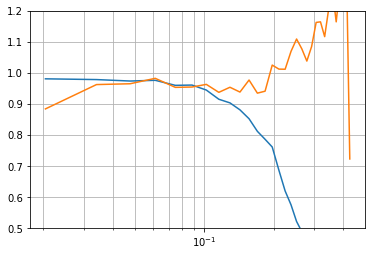

In [24]:
bmodeltf = datamodel.biasfield(xx, bias).numpy()
k, ph = tools.power(yy[0], boxsize=bs)
k, pb = tools.power(bmodeltf[0], boxsize=bs)
k, px = tools.power(yy[0], f2=bmodeltf[0], boxsize=bs)

plt.plot(k, px/(pb*ph)**0.5)
plt.plot(k, (pb/ph)**0.5)
plt.semilogx()
plt.ylim(0.5, 1.2)
plt.grid(which='both')

In [25]:


stdpred, displaced, random = standardrecon(tf.constant(yy), 
                                           tf.expand_dims(tf.constant(hpos, dtype=tf.float32), 0),
                                           tf.constant(bias1, dtype=tf.float32), R=tf.constant(128, dtype=tf.float32))



In [26]:
lr = 0.5

x_initstd = np.load('/mnt/ceph/users/cmodi/cosmo4d/z00/L0400_N%04d_D0010/stdR128_S%04d.npy'%(nc, seed))
x_initstd = (x_initstd / bias1).astype(np.float32).reshape(1, nc, nc, nc)

if args.stdinit: x_init = x_initstd 
else: x_init = np.random.normal(size=xx.size).reshape(xx.shape).astype(np.float32)
    
print("Loss at truth : ", datamodel.recon(tf.constant(xx), tf.constant(yy),  *[bias, errormesh]))
print("Loss at init : ", datamodel.recon(tf.constant(x_init), tf.constant(yy),  *[bias, errormesh]))

pred_adam = datamodel.reconstruct(tf.constant(yy), bias, errormesh, RRs=[0.0], niter=args.rim_iter, lr=lr, x_init=x_init)
print("Loss at adam 10x : ", datamodel.recon(tf.constant(pred_adam[0]), tf.constant(yy),  *[bias, errormesh]))


pred_adam10 = datamodel.reconstruct(tf.constant(yy), bias, errormesh, RRs=[0.0], niter=args.rim_iter*10, lr=lr, x_init=x_init)
print("Loss at adam 10x : ", datamodel.recon(tf.constant(pred_adam10[0]), tf.constant(yy),  *[bias, errormesh]))

minic, minfin = datamodel.reconstruct(tf.constant(yy), bias, errormesh, RRs=[2.0, 1.0, 0.0], niter=args.rim_iter*20, lr=lr, x_init=x_init)
print("Loss at best recon: ", datamodel.recon(tf.constant(minic), tf.constant(yy),  *[bias, errormesh]))

compares =  [stdpred, pred_adam, pred_adam10, [minic[0], minfin[0]]]
print('Test set generated')


RIM does not use prior

Loss at truth :  (<tf.Tensor: shape=(), dtype=float32, numpy=0.00050717336>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00050717336>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)
Loss at init :  (<tf.Tensor: shape=(), dtype=float32, numpy=0.0019729761>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0019729761>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)
reconstructing
For smoothing scale :  0.0

Add annealing section to graph


minimized

Loss at adam 10x :  (<tf.Tensor: shape=(), dtype=float32, numpy=0.0013720673>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0013720673>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)
reconstructing
For smoothing scale :  0.0

Add annealing section to graph


minimized

Loss at adam 10x :  (<tf.Tensor: shape=(), dtype=float32, numpy=0.00073150964>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00073150964>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)
reconstructing
For smoothing scale :  2.0

Add annealing sec

# LBFGS

In [27]:
# cosmo4d = '/mnt/ceph/users/cmodi/cosmo4d-recon/z00/L0400-N0064-S0100/opt_s999_mass_fourier_LPT/datap/s//
cosmo4d = '/mnt/ceph/users/cmodi/cosmo4d-recon/z00/L%04d-N%04d-S0100/opt_s999_%s_fourier_LPT/'%(bs, nc, datatype)
datalfgs = [tools.readbigfile(cosmo4d + 'datap/s/'), tools.readbigfile(cosmo4d + 'datap/mapp/')]
fitlbfgs = [tools.readbigfile(cosmo4d + '/%d-0.00/best-fit/s/'%nc), tools.readbigfile(cosmo4d + '/%d-0.00/best-fit/mapp/'%nc)]

# RIM

In [28]:
rim_grad_fn = datamodel.recon_grad 
grad_params = [bias, errormesh]
b1, b2 = bias[0].numpy(), bias[1].numpy()


In [29]:


#RIM params
params = {}
params['input_size'] = 8
params['cell_size'] = 8
params['strides'] = 2
params['middle_size'] = args.input_size // params['strides']  #lets divide by strides
params['cell_kernel_size'] = 5
params['input_kernel_size'] = 5
params['middle_kernel_size'] = 5
params['output_kernel_size'] = 5
params['rim_iter'] = args.rim_iter
params['input_activation'] = 'tanh'
params['output_activation'] = 'linear'
params['nc'] = nc

params16 = params.copy()
params16['input_size'] = 16
params16['cell_size'] = 16


In [30]:
'../code/clean_rim/models/L0400_N064/LPT2_halo_cutoff_w4_pos_lr//'

'../code/clean_rim/models/L0400_N064/LPT2_halo_cutoff_w4_pos_lr//'

In [31]:
if args.stdinit: stdstring = '_std'
else: stdstring  = ''

rimfolder = '../code/clean_rim/models/L0400_N%03d/LPT2_halo_cutoff_w4_%s%s/'%(nc, datatype, stdstring)
# rimfolder = '../code/clean_rim/models/L0400_N%03d/LPT2_halo_cutoff_w4_pos_lr5p4_decay500/'
print(rimfolder)
rim = build_rim_parallel(params)
for i in range(40, 30, -1):    
    try: 
        rim.load_weights(rimfolder+"%d"%i)
        break
    except: pass
print('checkpoint %d loaded'%i)
allpred = rim(tf.constant(x_init), tf.constant(yy), rim_grad_fn, grad_params)
pred = allpred[-1]

rimfolder16 = '../code/clean_rim/models/L0400_N%03d/LPT2_halo_cutoff_w4_%s%s_16ly/'%(nc, datatype, stdstring)
# rimfolder16 = '../code/clean_rim/models/L0400_N%03d/LPT2_halo_cutoff_w4_pos_lr5p4_16ly_decay100/'
print(rimfolder16)
rim16 = build_rim_parallel(params16)
for i in range(40, 30, -1):    
    try: 
        rim16.load_weights(rimfolder16+"%d"%i)
        break
    except: pass
print('checkpoint %d loaded'%i)
allpred16 = rim16(tf.constant(x_init), tf.constant(yy), rim_grad_fn, grad_params)
pred16 = allpred16[-1]



../code/clean_rim/models/L0400_N032/LPT2_halo_cutoff_w4_pos/
checkpoint 39 loaded

RIM does not use prior

../code/clean_rim/models/L0400_N032/LPT2_halo_cutoff_w4_pos_16ly/
checkpoint 39 loaded


In [32]:
def get_ps(iterand, truth):
    pks = []
    nsim = len(iterand)
    for i in range(nsim):
        a, b = iterand[i].copy(), truth[i].copy()
        if abs(a.mean()) < 1e-1: a += 1
        if abs(b.mean()) < 1e-1: b += 1
        k, p1 = tools.power(a, boxsize=bs)
        k, p2 = tools.power(b, boxsize=bs)
        k, px = tools.power(a, f2=b, boxsize=bs)
        pks.append([p1, p2, px])
    return k, pks


./figs/L0400_N0032_pos


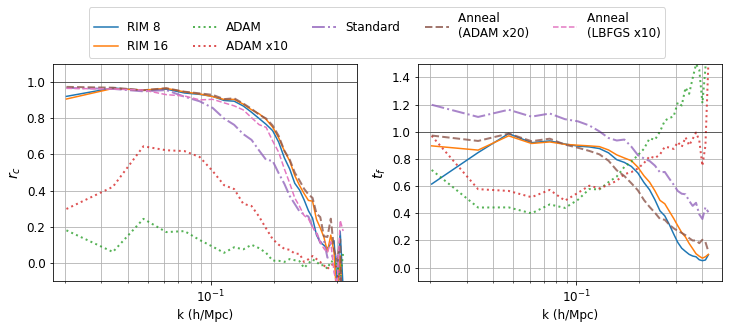

In [33]:
toplot = [pred, pred16, pred_adam[0], pred_adam10[0], stdpred, minic]
labels = ['RIM 8', 'RIM 16', 'ADAM', 'ADAM x10', 'Standard', 'Anneal \n(ADAM x20)']
lss = ['-', '-', ':', ':', '-.', '--']

fig, ax = plt.subplots(1, 2, figsize = (12, 4), sharex=True)

for i in range(len(toplot)):
    k, ps = get_ps([toplot[i].numpy()[0] ], [xx[0]])
    if lss[i] != '-' : alpha, lw = 0.8, 2
    else: alpha, lw = 1, 1.5
    ax[0].plot(k, ps[0][2]/(ps[0][0]*ps[0][1])**0.5, label=labels[i], ls=lss[i], lw=lw, alpha=alpha)
    ax[1].plot(k, (ps[0][0]/ps[0][1])**0.5, ls=lss[i], lw=lw, alpha=alpha)

k, ps = get_ps([fitlbfgs[0]], [datalfgs[0]])
ax[0].plot(k, ps[0][2]/(ps[0][0]*ps[0][1])**0.5, label='Anneal \n(LBFGS x10)', ls="--")
ax[1].plot(k, (ps[0][0]/ps[0][1])**0.5, ls="--")

ax[0].set_ylim(-0.1, 1.1)
ax[1].set_ylim(-0.1, 1.5)
ax[0].set_ylabel('$r_c$', fontsize=14)
ax[1].set_ylabel('$t_f$', fontsize=14)

for axis in ax:
    axis.grid(which='both')
    lgd = ax[0].legend(fontsize=12, bbox_to_anchor=(0.1, 1.), ncol=5, loc='lower left')
    axis.semilogx()
    axis.set_xlabel('k (h/Mpc)', fontsize=12)
    axis.tick_params(axis='both', which='major', labelsize=12)    
    axis.axhline(1, color='k', lw=0.5)
suff = ''
fname = './figs/L%04d_N%04d_%s%s'%(bs, nc, datatype, stdstring)
print(fname)
# plt.tight_layout(rect=[0, 0, 1.0, 0.9])
# plt.savefig(fname + '.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(fname + '.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')


./figs/L0400_N0032_pos-2ptniters


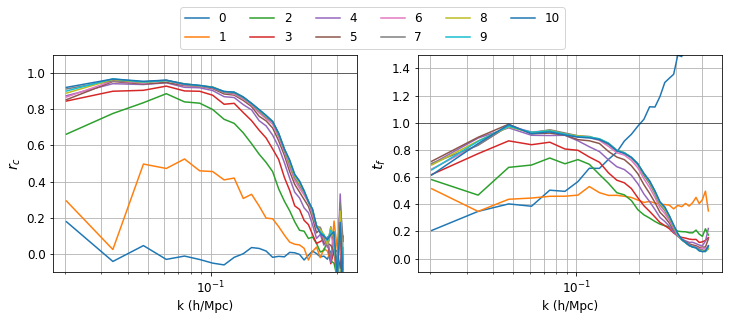

In [34]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4), sharex=True)
for i in range(allpred.shape[0]):
    xpred = allpred[i].numpy()[0]
    k, ps = get_ps([xpred], [xx[0]])
    ax[0].plot(k, ps[0][2]/(ps[0][0]*ps[0][1])**0.5, label=i)
    ax[1].plot(k, (ps[0][0]/ps[0][1])**0.5)

ax[0].set_ylim(-0.1, 1.1)
ax[1].set_ylim(-0.1, 1.5)
ax[0].set_ylabel('$r_c$', fontsize=14)
ax[1].set_ylabel('$t_f$', fontsize=14)

for axis in ax:
    axis.grid(which='both')
    lgd = ax[0].legend(fontsize=12, bbox_to_anchor=(0.4, 1.), ncol=6, loc='lower left')
    axis.semilogx()
    axis.set_xlabel('k (h/Mpc)', fontsize=12)
    axis.tick_params(axis='both', which='major', labelsize=12)    
    axis.axhline(1, color='k', lw=0.5)
suff = '-2ptniters'
fname = './figs/L%04d_N%04d_%s%s%s'%(bs, nc, datatype, stdstring, suff)
print(fname)
# plt.tight_layout()
# plt.savefig(fname + '.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(fname + '.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')



./figs/L0400_N0032_pos-imniters


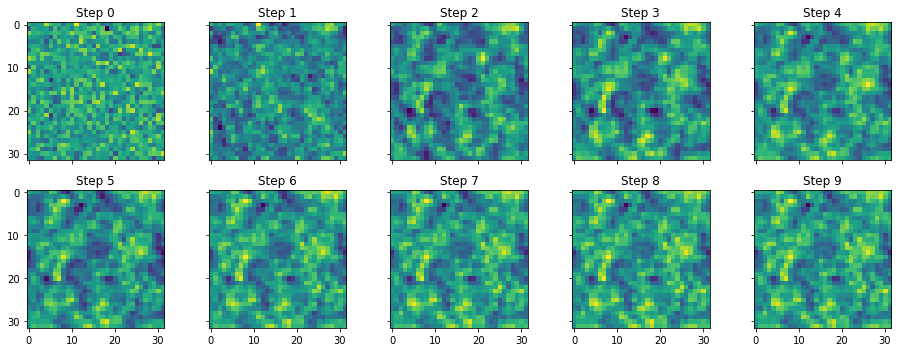

In [35]:
fig, ax = plt.subplots(2, 5, figsize=(13, 5), sharex=True, sharey=True)
for i in range(10):
    axis = ax.flatten()[i]
    axis.imshow(allpred[i][0].numpy().sum(axis=0))
    axis.set_title("Step %d"%i)

plt.tight_layout()
suff = '-imniters'
fname = './figs/L%04d_N%04d_%s%s%s'%(bs, nc, datatype, stdstring, suff)
print(fname)
# plt.savefig(fname + '.png')
# plt.savefig(fname + '.pdf')
plt.show()



# Compare updates

In [36]:
def reconstruct(data, bias, errormesh, RRs=[1.0, 0.0], niter=100, lr=0.1, x_init=None, useprior=True):

    print('reconstructing')

    @tf.function
    def grad(x, Rsm):
        with tf.GradientTape() as tape:
            tape.watch(x)
            loss = datamodel.reconstruct_loss(x, data, bias, errormesh, Rsm, useprior=useprior)
        grad = tape.gradient(loss, x)
        return grad


    # Create an optimizer for Adam.
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    ##Reconstruction
    if x_init is None: 
        x_init = np.random.normal(0, 1, nc**3).reshape(data.shape).astype(np.float32) 
    linear = tf.Variable(name='linmesh', shape=data.shape, dtype=tf.float32,
                             initial_value=x_init, trainable=True)


    adamupdates = []
    for iR, RR in enumerate(RRs):
        print('For smoothing scale : ', RR)
        for i in range(niter):
            grads = grad([linear], tf.constant(RR, dtype=tf.float32))
            opt.apply_gradients(zip(grads, [linear]))
        minic = tf.reshape(linear, data.shape)
    #
    print('\nminimized\n')
    minsample = datamodel.biasfield(minic, bias) #tf.constant(minic, dtype=tf.float32), bias).numpy()

    return minic, minsample


# Improve RIM


In [171]:
params2x = params.copy()
params2x['rim_iter'] = 20 

In [172]:
rim2x = build_rim_parallel(params2x)
for i in range(40, 30, -1):    
    try: 
        rim2x.load_weights(rimfolder+"%d"%i)
        break
    except: pass
print('checkpoint %d loaded'%i)
allpred2x = rim2x(tf.constant(x_init), tf.constant(yy), rim_grad_fn, grad_params)
pred2x = allpred2x[-1]


checkpoint 39 loaded


In [173]:
rimadam = datamodel.reconstruct(tf.constant(yy), bias, errormesh, RRs=[0.0], niter=args.rim_iter*20, lr=0.5, x_init=pred)


reconstructing
For smoothing scale :  0.0

Add annealing section to graph


minimized



./figs/L0400_N0032_pos-improve


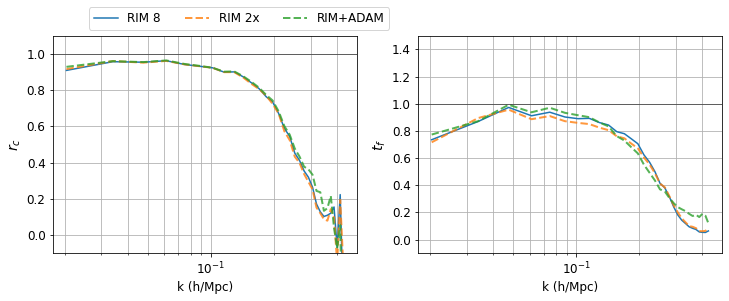

In [174]:
toplot = [pred, pred2x, rimadam[0], pred16,  minic]
labels = ['RIM 8', 'RIM 2x', 'RIM+ADAM', 'RIM 16', 'Anneal \n(ADAM x20)']
lss = ['-', '--', '--', ':', '-.']

fig, ax = plt.subplots(1, 2, figsize = (12, 4), sharex=True)

for i in range(3):
# for i in range(len(toplot)):
    k, ps = get_ps([toplot[i].numpy()[0] ], [xx[0]])
    if lss[i] != '-' : alpha, lw = 0.8, 2
    else: alpha, lw = 1, 1.5
    ax[0].plot(k, ps[0][2]/(ps[0][0]*ps[0][1])**0.5, label=labels[i], ls=lss[i], lw=lw, alpha=alpha)
    ax[1].plot(k, (ps[0][0]/ps[0][1])**0.5, ls=lss[i], lw=lw, alpha=alpha)

# k, ps = get_ps([fitlbfgs[0]], [datalfgs[0]])
# ax[0].plot(k, ps[0][2]/(ps[0][0]*ps[0][1])**0.5, label='Anneal \n(LBFGS x10)', ls="-.")
# ax[1].plot(k, (ps[0][0]/ps[0][1])**0.5, ls="-.")

ax[0].set_ylim(-0.1, 1.1)
ax[1].set_ylim(-0.1, 1.5)
ax[0].set_ylabel('$r_c$', fontsize=14)
ax[1].set_ylabel('$t_f$', fontsize=14)

for axis in ax:
    axis.grid(which='both')
    lgd = ax[0].legend(fontsize=12, bbox_to_anchor=(0.1, 1.), ncol=5, loc='lower left')
    axis.semilogx()
    axis.set_xlabel('k (h/Mpc)', fontsize=12)
    axis.tick_params(axis='both', which='major', labelsize=12)    
    axis.axhline(1, color='k', lw=0.5)
suff = '-improve'
fname = './figs/L%04d_N%04d_%s%s%s'%(bs, nc, datatype, stdstring, suff)
print(fname)
# plt.savefig(fname + '.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(fname + '.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')


# Standard

In [175]:
stdstring = '_std'

rimfolder = '../code/clean_rim/models/L0400_N%03d/LPT2_halo_cutoff_w4_%s%s/'%(nc, datatype, stdstring)
print(rimfolder)
rimstd = build_rim_parallel(params)
for i in range(40, 30, -1):    
    try: 
        rimstd.load_weights(rimfolder+"%d"%i)
        break
    except: pass
print('checkpoint %d loaded'%i)
allpredstd = rimstd(tf.constant(x_initstd), tf.constant(yy), rim_grad_fn, grad_params)
predstd = allpredstd[-1]

rimfolder16 = '../code/clean_rim/models/L0400_N%03d/LPT2_halo_cutoff_w4_%s%s_16ly/'%(nc, datatype, stdstring)
print(rimfolder16)
rim16std = build_rim_parallel(params16)
for i in range(40, 30, -1):    
    try: 
        rim16std.load_weights(rimfolder16+"%d"%i)
        break
    except: pass
print('checkpoint %d loaded'%i)
allpred16std = rim16std(tf.constant(x_initstd), tf.constant(yy), rim_grad_fn, grad_params)
pred16std = allpred16std[-1]



../code/clean_rim/models/L0400_N032/LPT2_halo_cutoff_w4_pos_std/
checkpoint 39 loaded
../code/clean_rim/models/L0400_N032/LPT2_halo_cutoff_w4_pos_std_16ly/
checkpoint 39 loaded


./figs/L0400_N0032_pos_std


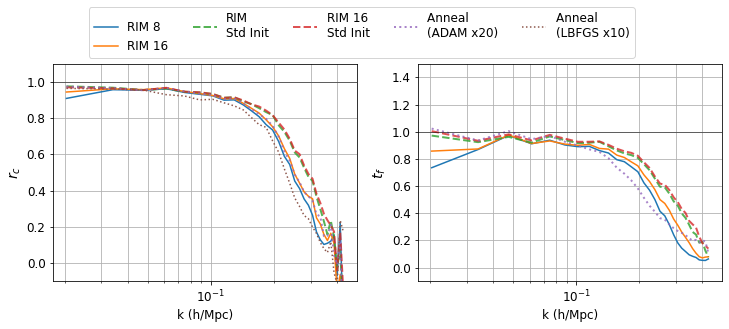

In [176]:
toplot = [pred, pred16,  predstd, pred16std, minic]
labels = ['RIM 8', 'RIM 16', 'RIM\nStd Init', 'RIM 16\nStd Init', 'Anneal \n(ADAM x20)']
lss = ['-', '-', '--', '--', ':']

fig, ax = plt.subplots(1, 2, figsize = (12, 4), sharex=True)

# for i in range(3):
for i in range(len(toplot)):
    k, ps = get_ps([toplot[i].numpy()[0] ], [xx[0]])
    if lss[i] != '-' : alpha, lw = 0.8, 2
    else: alpha, lw = 1, 1.5
    ax[0].plot(k, ps[0][2]/(ps[0][0]*ps[0][1])**0.5, label=labels[i], ls=lss[i], lw=lw, alpha=alpha)
    ax[1].plot(k, (ps[0][0]/ps[0][1])**0.5, ls=lss[i], lw=lw, alpha=alpha)

k, ps = get_ps([fitlbfgs[0]], [datalfgs[0]])
ax[0].plot(k, ps[0][2]/(ps[0][0]*ps[0][1])**0.5, label='Anneal \n(LBFGS x10)', ls=":")
ax[1].plot(k, (ps[0][0]/ps[0][1])**0.5, ls="-.")

ax[0].set_ylim(-0.1, 1.1)
ax[1].set_ylim(-0.1, 1.5)
ax[0].set_ylabel('$r_c$', fontsize=14)
ax[1].set_ylabel('$t_f$', fontsize=14)

for axis in ax:
    axis.grid(which='both')
    lgd = ax[0].legend(fontsize=12, bbox_to_anchor=(0.1, 1.), ncol=5, loc='lower left')
    axis.semilogx()
    axis.set_xlabel('k (h/Mpc)', fontsize=12)
    axis.tick_params(axis='both', which='major', labelsize=12)    
    axis.axhline(1, color='k', lw=0.5)
suff = ''
fname = './figs/L%04d_N%04d_%s%s%s'%(bs, nc, datatype, stdstring, suff)
print(fname)
# plt.savefig(fname + '.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(fname + '.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')


In [177]:
rimadamstd = datamodel.reconstruct(tf.constant(yy), bias, errormesh, RRs=[0.0], niter=args.rim_iter*20, lr=0.5, x_init=predstd)


reconstructing
For smoothing scale :  0.0

Add annealing section to graph


minimized



In [178]:
# toplot = [pred, rimadam[0],  predstd, rimadamstd[0], minic]
# labels = ['RIM 8', 'RIM Adam', 'RIM\nStd Init', 'RIM Adam\nStd Init', 'Anneal \n(ADAM x20)']
# lss = ['-', '-', '--', '--', ':']

# fig, ax = plt.subplots(1, 2, figsize = (12, 4), sharex=True)

# # for i in range(3):
# for i in range(len(toplot)):
#     k, ps = get_ps([toplot[i].numpy()[0] ], [xx[0]])
#     if lss[i] != '-' : alpha, lw = 0.8, 2
#     else: alpha, lw = 1, 1.5
#     ax[0].plot(k, ps[0][2]/(ps[0][0]*ps[0][1])**0.5, label=labels[i], ls=lss[i], lw=lw, alpha=alpha)
#     ax[1].plot(k, (ps[0][0]/ps[0][1])**0.5, ls=lss[i], lw=lw, alpha=alpha)

# # k, ps = get_ps([fitlbfgs[0]], [datalfgs[0]])
# # ax[0].plot(k, ps[0][2]/(ps[0][0]*ps[0][1])**0.5, label='Anneal \n(LBFGS x10)', ls=":")
# # ax[1].plot(k, (ps[0][0]/ps[0][1])**0.5, ls="-.")

# ax[0].set_ylim(-0.1, 1.1)
# ax[1].set_ylim(-0.1, 1.5)
# ax[0].set_ylabel('$r_c$', fontsize=14)
# ax[1].set_ylabel('$t_f$', fontsize=14)

# for axis in ax:
#     axis.grid(which='both')
#     ax[0].legend(fontsize=12, bbox_to_anchor=(0.1, 1.), ncol=5, loc='lower left')
# #     axis.semilogx()
#     axis.set_xlabel('k (h/Mpc)', fontsize=12)
#     axis.tick_params(axis='both', which='major', labelsize=12)    
#     axis.axhline(1, color='k', lw=0.5)
# suff = ''
# fname = './figs/L%04d_N%04d_%s%s%s'%(bs, nc, datatype, stdstring, suff)
# print(fname)
# # plt.savefig(fname + '.png')
# # plt.savefig(fname + '.pdf')


# RESNET

In [179]:
from cnn_utils import SimpleUNet
cnn = SimpleUNet(32, kernel_size=5)

In [180]:
cnn.load_weights('../code/clean_rim/models/L0400_N032/LPT2_halo_unet_test/99')

In [185]:
ipkdiff, b1eul = get_diff_spectra(args, ipklin, nsims=10, nsteps=args.nsteps)

alldata shape : (100, 3, 32, 32, 32)


In [186]:
x_initcnn = x_initstd + linear_field(nc, bs, ipkdiff, batch_size=x_initstd.shape[0])

In [191]:
predcnn = cnn(tf.expand_dims(x_initcnn, -1))[..., 0]

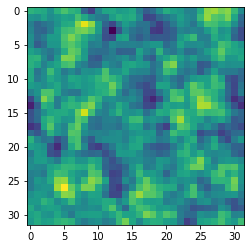

In [192]:
plt.imshow(predcnn.numpy()[0, ...].sum(axis=0))

./figs/L0400_N0032_pos_unet


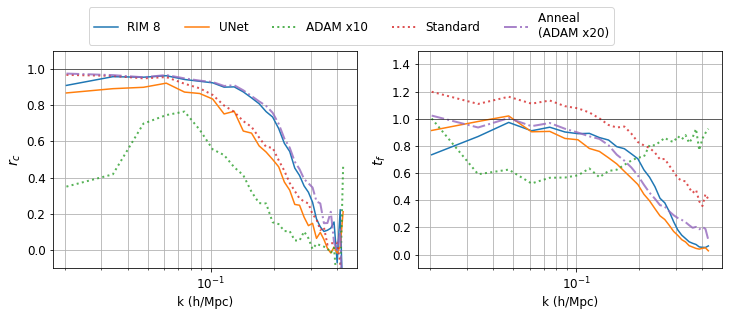

In [199]:
toplot = [pred, predcnn, pred_adam10[0], stdpred, minic]
labels = ['RIM 8', 'UNet', 'ADAM x10', 'Standard', 'Anneal \n(ADAM x20)']
lss = ['-', '-', ':', ':', '-.', '--']

fig, ax = plt.subplots(1, 2, figsize = (12, 4), sharex=True)

for i in range(len(toplot)):
    k, ps = get_ps([toplot[i].numpy()[0] ], [xx[0]])
    if lss[i] != '-' : alpha, lw = 0.8, 2
    else: alpha, lw = 1, 1.5
    ax[0].plot(k, ps[0][2]/(ps[0][0]*ps[0][1])**0.5, label=labels[i], ls=lss[i], lw=lw, alpha=alpha)
    ax[1].plot(k, (ps[0][0]/ps[0][1])**0.5, ls=lss[i], lw=lw, alpha=alpha)

# k, ps = get_ps([fitlbfgs[0]], [datalfgs[0]])
# ax[0].plot(k, ps[0][2]/(ps[0][0]*ps[0][1])**0.5, label='Anneal \n(LBFGS x10)', ls="--")
# ax[1].plot(k, (ps[0][0]/ps[0][1])**0.5, ls="--")

ax[0].set_ylim(-0.1, 1.1)
ax[1].set_ylim(-0.1, 1.5)
ax[0].set_ylabel('$r_c$', fontsize=14)
ax[1].set_ylabel('$t_f$', fontsize=14)

for axis in ax:
    axis.grid(which='both')
    lgd = ax[0].legend(fontsize=12, bbox_to_anchor=(0.1, 1.), ncol=5, loc='lower left')
    axis.semilogx()
    axis.set_xlabel('k (h/Mpc)', fontsize=12)
    axis.tick_params(axis='both', which='major', labelsize=12)    
    axis.axhline(1, color='k', lw=0.5)
suff = '_unet'
fname = './figs/L%04d_N%04d_%s%s'%(bs, nc, datatype, suff)
print(fname)
# plt.tight_layout(rect=[0, 0, 1.0, 0.9])
plt.savefig(fname + '.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(fname + '.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')


# Compare updates

In [37]:
from convolutional_recurrent import ConvLSTM3DCell
from tensorflow.python.keras.layers import Conv3D, Conv3DTranspose, MaxPool3D, AveragePooling3D


class RIM3D_parallel_updates(tf.keras.Model):

    def __init__(self, cell1, cell2, input_layer, input_layer_sub, output_layer_up, output_layer, strides, niter):
        super(RIM3D_parallel_updates, self).__init__()
        self.cell1 = cell1
        self.cell2 = cell2
        self.output_layer = output_layer
        self.output_layer_up = output_layer_up
        self.input_layer = input_layer
        self.input_layer_sub = input_layer_sub
        self.strides = strides
        self.niter = niter
        self.beta_1, self.beta_2 = 0.9, 0.999
        self.lr, self.eps = 0.1, 1e-7
            
            
    def call(self, x_init, y, grad_fn, grad_args=[], initstates = None, return_steps=False):

        outputs_ta = tf.TensorArray(size=self.niter+1, dtype=tf.float32)
        inputs_ta = tf.TensorArray(size=self.niter+1, dtype=tf.float32)

        
        if initstates is None: 
            #stateshape = tuple(i//self.strides for i in x_init.shape) + tuple([self.cell1.filters])
            #stateshape = x_init.shape + tuple([self.cell.filters])
            #initstates = [tf.zeros(stateshape), tf.zeros(stateshape)]
            nc2 = int(x_init.shape[1]/self.strides)
            stateshape = (x_init.shape[0], nc2, nc2, nc2, self.cell1.filters)
            initstates1 = [tf.zeros(stateshape), tf.zeros(stateshape)]
            stateshape = x_init.shape + tuple([self.cell2.filters])
            initstates2 = [tf.zeros(stateshape), tf.zeros(stateshape)]
            initstates = [initstates1, initstates2]

        i = tf.constant(0, dtype=tf.int32)
        curr_state = initstates
        curr_pos = x_init        
        m = tf.zeros_like(x_init)
        v = tf.zeros_like(x_init)
        
        def body(i, pos, states, m, v):  
            gradient = grad_fn(pos, y, *grad_args)           
            t = tf.cast(i+1, tf.float32)
            m = self.beta_1*m + (1-self.beta_1)*gradient
            v = self.beta_2*v + (1-self.beta_2)*gradient**2
            mc = m/(1-self.beta_1**t)
            vc = v/(1-self.beta_2**t)
            delta = -1.*self.lr*mc/(tf.sqrt(vc) + self.eps)
            #
            states1, states2 = states
            concat_input = tf.stack([pos, delta], axis=-1)
            #
            cell_input_sub = self.input_layer_sub(concat_input)
            delta_pos1, new_states1 = self.cell1(cell_input_sub, states1)
            delta_pos1 = self.output_layer_up(delta_pos1) 
            #
            cell_input = self.input_layer(concat_input)
            delta_pos2, new_states2 = self.cell2(cell_input, states2)
            #delta_pos2 = self.output_layer(delta_pos2)
            #
            #delta_pos = delta_pos1 + delta_pos2
            delta_pos = tf.concat([delta_pos1, delta_pos2], axis=-1)
            delta_pos = self.output_layer(delta_pos)
            new_pos = pos + delta_pos[..., 0]
            new_states = [new_states1, new_states2]
            return i + 1 , new_pos, new_states, m, v, tf.stack([delta, delta_pos[...,0]], -1)


        while tf.less(i, tf.constant(self.niter)):
            outputs_ta = outputs_ta.write(i, curr_pos)
            i, curr_pos, curr_state, m, v, delta =  body(i, curr_pos, curr_state, m, v)
            inputs_ta = inputs_ta.write(i, delta)
        outputs_ta = outputs_ta.write(i, curr_pos)
        return outputs_ta.stack(), inputs_ta.stack()




def build_rim_parallel_updates(params):

    nc = params['nc']
    input_layer = Conv3D(params['input_size'], kernel_size=params['input_kernel_size'], 
                         trainable=True, padding='SAME', 
                         input_shape=(None, nc, nc, nc, 2), activation=params['input_activation'])

    input_layer_sub = Conv3D(params['input_size'], kernel_size=params['input_kernel_size'], 
                             trainable=True, padding='SAME', strides= [params['strides']]*3,
                             input_shape=(None, nc, nc, nc, 2), activation=params['input_activation'])

    cell1 = ConvLSTM3DCell(params['cell_size'], kernel_size=params['cell_kernel_size'], padding='SAME')

    output_layer_up = Conv3DTranspose(params['cell_size'], kernel_size=params['middle_kernel_size'], 
                         trainable=True, padding='SAME', strides=[params['strides']]*3, 
                         activation=params['output_activation'])

    cell2 = ConvLSTM3DCell(params['cell_size'], kernel_size=params['cell_kernel_size'], padding='SAME')

    output_layer = Conv3D(1, kernel_size=params['output_kernel_size'], trainable=True, padding='SAME', 
                          input_shape=(None, nc, nc, nc, params['cell_size']*2), activation=params['output_activation'])
   
    rim = RIM3D_parallel_updates(cell1, cell2, input_layer, input_layer_sub, output_layer_up, output_layer, strides=params['strides'],
                       niter=params['rim_iter'])

    return rim



In [44]:
rim_updates = build_rim_parallel_updates(params)
for i in range(40, 30, -1):    
    try: 
        rim_updates.load_weights(rimfolder+"%d"%i)
        break
    except: pass
print('checkpoint %d loaded'%i)
allpred_updates = rim_updates(tf.constant(x_init), tf.constant(yy), rim_grad_fn, grad_params)


checkpoint 39 loaded


In [45]:
riters, aiters = allpred_updates[0].numpy(), allpred_updates[1].numpy()

In [46]:
# ii = 1
# (riters[ii+1] - riters[ii])/aiters[ii+1, ..., 1]

No handles with labels found to put in legend.


[-0.00387937 -0.05094456]
[-0.00287025  0.05687902]
[-0.00201298 -0.01232474]
[-0.00149995 -0.01527717]
[-0.0011167  -0.00336954]
[-0.00089224  0.00123195]
[-0.00072168  0.0017868 ]
[-0.00060512  0.00467564]
[-0.00053675  0.0061977 ]
[-0.00047041  0.0042041 ]


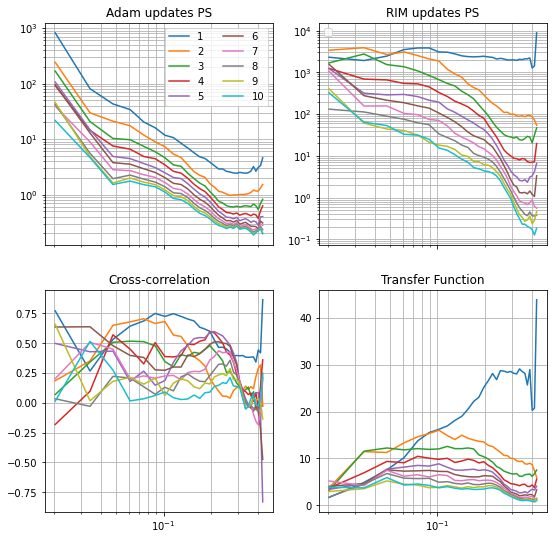

In [106]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9),sharex=True)

for i in range(1, 11):
    print(aiters[i].mean(axis=(0, 1, 2, 3)))
    k, pa = tools.power(aiters[i, 0, ..., 0]+1, boxsize=bs)
    k, pr = tools.power(aiters[i, 0, ..., 1]+1, boxsize=bs)
    k, px = tools.power(aiters[i, 0, ..., 1]+1, f2=aiters[i, 0, ..., 0]+1, boxsize=bs)
    
    ax[0, 0].plot(k, pa, label=i)
    ax[0, 1].plot(k, pr)
    ax[1, 0].plot(k, px/(pa*pr)**0.5)
    ax[1, 1].plot(k, (pr/pa)**0.5)
for axis in ax[1]: 
    axis.semilogx()
for axis in ax[0]: 
    axis.loglog()
    axis.legend(ncol=2)

ax[0, 0].set_title('Adam updates PS')
ax[0, 1].set_title('RIM updates PS')
ax[1, 0].set_title('Cross-correlation')
ax[1, 1].set_title('Transfer Function')

for axis in ax.flatten(): axis.grid(which='both')

In [107]:
# for i in range(1, 11):
#     fig, ax = plt.subplots(1, 2, figsize=(9, 4))
#     ax[0].imshow(aiters[i,0,...,0].sum(axis=0))
#     ax[1].imshow(aiters[i,0,...,1].sum(axis=0))
#     plt.show()
    

In [108]:
kedges = np.histogram(kmesh.flatten(), bins=nc)[1]
kbinmap = np.digitize(np.expand_dims(kmesh, 0), kedges, right=False).astype(int32)
kbinmap[kbinmap == kbinmap.max()] = kbinmap.max()-1
# kbinmap[:, 0, 0, 0] = 1
kbinmap -= 1
kbinmap = tf.constant(kbinmap)
kbincount = tfp.stats.count_integers(kbinmap)
kbinmapflat = tf.constant(kbinmap.numpy().flatten())


In [109]:
scatters = []
ii = 1

for ik in range(1, 31):
    scatters.append([(tf.abs(r2c3d(aiters[ii,...,0])))[kbinmap==ik].numpy(), (tf.abs(r2c3d(aiters[ii,...,1])))[kbinmap==ik].numpy()])

In [110]:
kmesh[kbinmap==ik].mean()

0.41159937

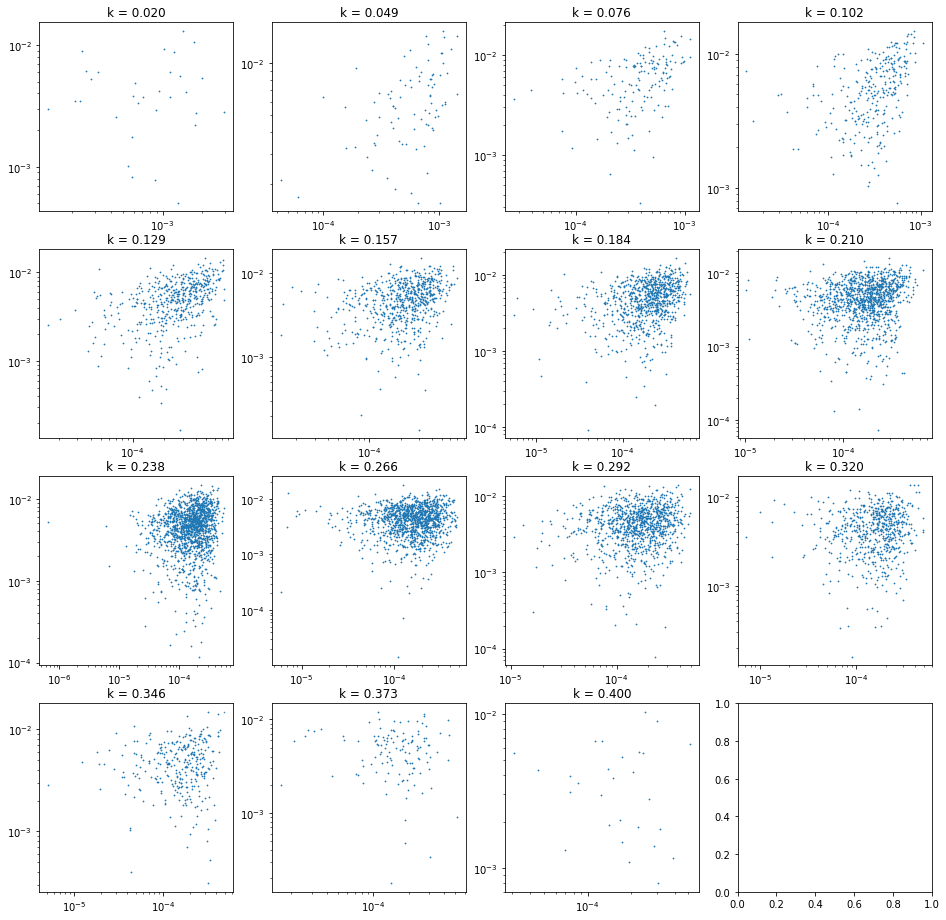

In [119]:
ik = 3

fig, axar = plt.subplots(4, 4, figsize=(16, 16))

i = 0 
for ik in range(1, 31, 2):
    ax = axar.flatten()[i]
    ax.plot(scatters[ik][0], scatters[ik][1],'.', ms=1)
    xmin = min([scatters[ik][0].min(), scatters[ik][1].min()])
    xmax = max([scatters[ik][0].max(), scatters[ik][1].max()])
#     ax.plot([xmin, xmax], [xmin, xmax], 'k')
    ax.loglog()
    ax.set_title('k = %0.3f'%kmesh[kbinmap==ik].mean())
    i+=1
    

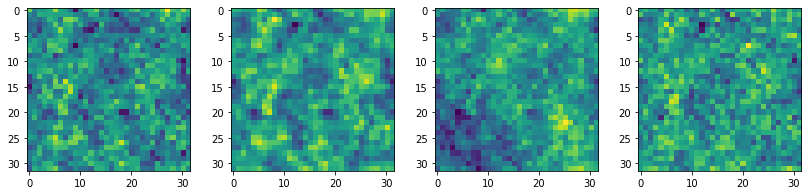

In [63]:
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].imshow(xx[0].sum(axis=0))
ax[1].imshow(pred[0].numpy().sum(axis=0))
ax[2].imshow(aiters.sum(axis=0)[0, ..., 0].sum(axis=0))
ax[3].imshow(aiters.sum(axis=0)[0, ..., 1].sum(axis=0))
plt.show()

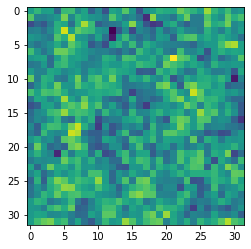

In [64]:
# def reconstruct(data, bias, errormesh, RRs=[1.0, 0.0], niter=100, lr=0.1, x_init=None, useprior=True):

#     print('reconstructing')

#     @tf.function
#     def grad(x, Rsm):
#         with tf.GradientTape() as tape:
#             tape.watch(x)
#             loss = datamodel.reconstruct_loss(x, data, bias, errormesh, Rsm, useprior=useprior)
#         grad = tape.gradient(loss, x)
#         return grad


#     # Create an optimizer for Adam.
#     opt = tf.keras.optimizers.Adam(learning_rate=lr)

#     ##Reconstruction
#     if x_init is None: 
#         x_init = np.random.normal(0, 1, nc**3).reshape(data.shape).astype(np.float32) 
#     linear = tf.Variable(name='linmesh', shape=data.shape, dtype=tf.float32,
#                              initial_value=x_init, trainable=True)


#     adamupdates = []
#     for iR, RR in enumerate(RRs):
#         print('For smoothing scale : ', RR)
#         for i in range(niter):
#             grads = grad([linear], tf.constant(RR, dtype=tf.float32))
#             opt.apply_gradients(zip(grads, [linear]))
#         minic = tf.reshape(linear, data.shape)
#     #
#     print('\nminimized\n')
#     minsample = datamodel.biasfield(minic, bias) #tf.constant(minic, dtype=tf.float32), bias).numpy()

#     return minic, minsample


In [ ]:
@tf.function
def grad(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = datamodel.reconstruct_loss(x, data, bias, errormesh, tf.constant(0.), useprior=useprior)
    grad = tape.gradient(loss, x)
    return grad

def grad2(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = datamodel.reconstruct_loss(x, data, bias, errormesh, tf.constant(0.), useprior=useprior)
        grad = tape.gradient(loss, x)
        
    return grad

    # Create an optimizer for Adam.
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    ##Reconstruction
    if x_init is None: 
        x_init = np.random.normal(0, 1, nc**3).reshape(data.shape).astype(np.float32) 
    linear = tf.Variable(name='linmesh', shape=data.shape, dtype=tf.float32,
                             initial_value=x_init, trainable=True)


    adamupdates = []
    for iR, RR in enumerate(RRs):
        print('For smoothing scale : ', RR)
        for i in range(niter):
            grads = grad([linear], tf.constant(RR, dtype=tf.float32))
            opt.apply_gradients(zip(grads, [linear]))
        minic = tf.reshape(linear, data.shape)
    #
    print('\nminimized\n')
    minsample = datamodel.biasfield(minic, bias) #tf.constant(minic, dtype=tf.float32), bias).numpy()

    return minic, minsample


In [66]:
tfxinit = tf.constant(x_init)